# Final Assignment

## Imports

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4746e4ed0b3705356451f06d286ddd3f8aa1ae71ea98a3cbf70202e50a4bee40
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import MNIST
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import wget
import zipfile

## Project DCGAN

## Dataset1 - CelebA

In [14]:
#download celebA dataset

data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)

implemented in the calss

### Generators

#### Origin generator

In [15]:
'''
This file contains the main DCGAN module.

The results may be obtained by running 'train()'
'''

class Generator(nn.Module):

    ''' Generator Model '''

    def __init__(self,ngpu, nz, ngf, nc):

        ''' initialising the variables '''

        super().__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        '''
        Building the model -

        We have 4 fractionally-strided convolutions to help the model learn it's own upsampling methods.

        Following the above are 4 batch normalization layers to stabilize the learning by normalizing the input to each unit to have zero mean and unit variance
        and to ease the geadient flow in deeper layers.

        Finally we have 4 ReLU activation layers which allows the model to learn more quickly and cover the complete spatial extent of an image.

        The final layer has a tanh activation function which limits the feature values between 0 and 1.

        '''

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias = False), #stride=1, padding=0
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  #stride=2, padding=1
            nn.Tanh()
        )

    ''' Function to forward the input into the model '''

    def forward(self,input):
        return self.main(input)

#### Generator with additional Self Attention layer

In [16]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    ''' Self-Attention Layer '''
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, kernel_size=1)
        self.value = nn.Conv2d(in_dim, in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, C, H, W = x.shape
        query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # B x (H*W) x C'
        key = self.key(x).view(B, -1, H * W)  # B x C' x (H*W)
        attention = self.softmax(torch.bmm(query, key))  # B x (H*W) x (H*W)

        value = self.value(x).view(B, -1, H * W)  # B x C x (H*W)
        out = torch.bmm(value, attention.permute(0, 2, 1))  # B x C x (H*W)
        out = out.view(B, C, H, W)
        return out + x  # Residual connection

class GeneratorSA(nn.Module):
    ''' Generator Model with Self-Attention '''
    def __init__(self, ngpu, nz, ngf, nc):
        super(GeneratorSA, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            # Self-Attention Layer added here
            SelfAttention(ngf*4),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

#### Generator with Layer Norm instead of Barch Norm

In [17]:
class LayerNormGenerator(nn.Module):
    def __init__(self, ngpu, nz, ngf, nc):
        super(LayerNormGenerator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.LayerNorm([ngf*8, 4, 4]),  # LayerNorm needs shape
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.LayerNorm([ngf*4, 8, 8]),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.LayerNorm([ngf*2, 16, 16]),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.LayerNorm([ngf, 32, 32]),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


#### Genrator with SiLU as activation function

In [18]:
'''
This file contains the main DCGAN module.

The results may be obtained by running 'train()'
'''

class Generator_SiLU(nn.Module):

    ''' Generator Model '''

    def __init__(self,ngpu, nz, ngf, nc):

        ''' initialising the variables '''

        super(Generator_SiLU, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        '''
        Building the model -

        We have 4 fractionally-strided convolutions to help the model learn it's own upsampling methods.

        Following the above are 4 batch normalization layers to stabilize the learning by normalizing the input to each unit to have zero mean and unit variance
        and to ease the geadient flow in deeper layers.

        Finally we have 4 ReLU activation layers which allows the model to learn more quickly and cover the complete spatial extent of an image.

        The final layer has a tanh activation function which limits the feature values between 0 and 1.

        '''

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias = False), #stride=1, padding=0
            nn.BatchNorm2d(ngf*8),
            nn.SiLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf*4),
            nn.SiLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf*2),
            nn.SiLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf),
            nn.SiLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  #stride=2, padding=1
            nn.Tanh()
        )

    ''' Function to forward the input into the model '''

    def forward(self,input):
        return self.main(input)

### Discriminators

In [19]:
class Discriminator(nn.Module):

    ''' Discriminator Model '''

    def __init__(self,ngpu,ndf,nc):

        ''' initialising the variables '''

        super(Discriminator,self).__init__()
        self.ngpu = ngpu
        self.ndf = ndf
        self.nc = nc

        '''
        Building the model -

        We have 4 convolution layers for downsampling.

        Following the above, we have 4 LeakyReLU activation layers which according to the paper gives better results on the discriminator specially for
        higher-resolution images.

        The final layer has a sigmoid activation function that outputs the probabilty of an image being fake or real.
        '''

        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False), #stride=1, padding=0
            nn.Sigmoid()
        )

    ''' Function to forward the input into the model '''

    def forward(self,input):
        return self.main(input)

## DataSet2 - MNIST

### Generators

#### Origin mnist

In [25]:
class Generator_mnist(nn.Module):

    ''' Generator Model for MNIST dataset '''

    def __init__(self,ngpu, nz, ngf, nc):

        ''' initialising the variables '''

        super(Generator_mnist,self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc

        '''
        Building the model -

        We have 4 fractionally-strided convolutions to help the model learn it's own upsampling methods.

        Following the above are 4 batch normalization layers to stabilize the learning by normalizing the input to each unit to have zero mean and unit variance
        and to ease the geadient flow in deeper layers.

        Finally we have 4 ReLU activation layers which allows the model to learn more quickly and cover the complete spatial extent of an image.

        The final layer has a tanh activation function which limits the feature values between 0 and 1.

        '''

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias = False), #stride=1, padding=0
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False), #stride=2, padding=1
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  #stride=2, padding=1
            nn.Tanh()
        )

    ''' Function to forward the input into the model '''

    def forward(self,input):
        return self.main(input)

### Discriminators

we chose not to change the discrminator, rather focus on generatorand loss changes

## Training Process

In [36]:
class DCGAN(object):

    def __init__(self, data = 'data/lsun', lr = 0.0002, beta1 = 0.5, ngpu = 1, relaxed_label_flag=False, chosen_generator='origin'):

        ''' initialising the variables '''

        self.dataroot = data
        self.batch_size = 128
        self.image_size = 64
        self.nc = 3
        self.nz = 100
        self.ngf = 64
        self.ndf = 64
        self.num_epochs = 5
        self.lr = lr
        self.beta1 = beta1
        self.ngpu = ngpu
        self.relaxed_label_flag = relaxed_label_flag
        self.device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
        self.generator_classes = {
          'origin': Generator(self.ngpu, self.nz, self.ngf, self.nc).to(self.device),
          'self_attention': GeneratorSA(self.ngpu, self.nz, self.ngf, self.nc).to(self.device),
          'layer_norm': LayerNormGenerator(self.ngpu, self.nz, self.ngf, self.nc).to(self.device),
          'SiLU': Generator_SiLU(self.ngpu, self.nz, self.ngf, self.nc).to(self.device),
          'origin_mnist': Generator_mnist(self.ngpu, self.nz, self.ngf, 1).to(self.device)
      }
        self.chosen_generator = self.generator_classes[chosen_generator]

    '''
    loading the dataset
    '''

    '''
    creating the dataset and dataloader
    '''

    def data_loader(self):
        ''' Creating the dataset '''

        if self.dataroot=='mnist':
        # Load dataset from the path
          print('mnist')
          dataset = MNIST(root=self.dataroot, train=True, download=True, transform=transforms.Compose([
              transforms.Resize(64),
              transforms.ToTensor(),
              transforms.Normalize((0.5,), (0.5,))
          ]))
          dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
          self.nc=1
        else:
            # Celeb A
          dataset = dset.ImageFolder(root = self.dataroot,
                                  transform = transforms.Compose([
                                  transforms.Resize(self.image_size),
                                  transforms.CenterCrop(self.image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                              ]))

          ''' Creating the dataloader '''
          dataloader = torch.utils.data.DataLoader(dataset, batch_size = self.batch_size,
                                                  shuffle = True)

        return dataloader


    '''
    randomly initializing model weights from a Normal distribution with mean = 0, stdev = 0.02 as mentioned in the DCGAN paper
    '''

    def weights_init(self, init_model):

        '''
        input: an initialized model

        output: reinitialized convolutional, convolutional-transpose, and batch normalization layers
        '''

        classname = init_model.__class__.__name__

        if classname.find('Conv') != -1:
            nn.init.normal_(init_model.weight.data, 0.0, 0.02)

        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(init_model.weight.data, 1.0, 0.02)
            nn.init.constant_(init_model.bias.data, 0)

  # loss function: we shall use the binary cross entropy loss as mentioned in the paper '''
    def hinge_loss_D(self, output_real, output_fake):
        loss_real = torch.mean(torch.relu(1.0 - output_real))  # max(0, 1 - D(x_real))
        loss_fake = torch.mean(torch.relu(1.0 + output_fake))  # max(0, 1 + D(G(z)))
        return loss_real + loss_fake

    def hinge_loss_G(self, output_fake):
      return -torch.mean(output_fake)  # Generator loss

    def train(self, path):

        ''' loading the data '''

        dataloader = self.data_loader()

        ''' Creating the generator '''
        netG = self.chosen_generator
        if (self.device.type == 'cuda') and (self.ngpu > 1):
            netG = nn.DataParallel(netG, list(range(self.ngpu)))

        ''' Apply the weights_init function to randomly initialize all weights from a distribution with mean=0, stdev=0.2 '''
        netG.apply(self.weights_init)

        ''' Creating the discriminator '''
        netD = Discriminator(self.ngpu, self.ndf, self.nc).to(self.device)

        if (self.device.type == 'cuda') and (self.ngpu > 1):
            netD = nn.DataParallel(netD, list(range(self.ngpu)))

        ''' Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2 '''
        netD.apply(self.weights_init)


        ''' loss function: we shall use the binary cross entropy loss as mentioned in the paper '''
        adversarial_loss = torch.nn.BCELoss()

        ''' Creating batch of latent vectors that we will use to visualize the progression of the generator '''
        fixed_noise = torch.randn(64, self.nz, 1, 1, device = self.device)

        ''' defining real label as 1 and the fake label as 0, to be used when calculating the losses of Discriminator and Generator '''
        if self.relaxed_label_flag:
          real_label = 0.9
          fake_label = 0.1
        else:
          real_label = 1
          fake_label = 0

        ''' setting up two separate Adam optimizers, for Discriminator and G as specified in the DCGAN papers, with learning rate 0.0002 and Beta1 = 0.5 '''
        optimizerD = optim.Adam(netD.parameters(), lr =self.lr, betas = (self.beta1, 0.999))
        optimizerG = optim.Adam(netG.parameters(), lr =self.lr, betas = (self.beta1, 0.999))

        '''
        Training:

        - construct different mini-batches for real and fake images, and adjust G’s objective function to maximize log(D(G(z)))

        - Discriminator Training: update the discriminator by ascending its stochastic gradient, maximize log(D(x))+log(1−D(G(z)))

        - Generator Training: train the Generator by minimizing log(1-D(G(z)))
        '''

        img_list = []
        G_losses = []
        D_losses = []
        iters = 0

        print('Training...')

        for epoch in range(self.num_epochs):
            for i, data in enumerate(dataloader, 0):

                ''' Training the Discriminator with real samples '''
                ''' updating Discriminator network: maximize log(D(x)) + log(1 - D(G(z))) '''
                netD.zero_grad()

                ''' creating batches of real samples from the dataset '''
                batch = data[0].to(self.device)
                b_size = batch.size(0)
                ''' creating the target tensor '''
                label = torch.full((b_size,), real_label, dtype=torch.float, device=self.device)
                ''' passing the batch of real samples through the discriminator '''
                output_real = netD(batch).view(-1)
                ''' calculating the discriminator error for real samples '''
                errorD_real = adversarial_loss(output_real, label)
                ''' calculating the gradients through backprop '''
                errorD_real.backward()
                Dx = output_real.mean().item()

                ''' Training the Discriminator with fake samples '''
                ''' generating a fake batch from the generator '''
                noise = torch.randn(b_size, self.nz, 1, 1, device=self.device)
                fake_batch = netG(noise)
                # print(fake_batch.shape)
                label.fill_(fake_label)
                ''' passing the batch of fake samples through the discriminator '''
                output_fake = netD(fake_batch.detach()).view(-1)
                ''' calculating the discriminator error for fake samples '''
                errorD_fake = adversarial_loss(output_fake, label)
                ''' calculating the gradients through backprop '''
                errorD_fake.backward()
                Dz = output_fake.mean().item()

                ''' computing the final discriminator error '''
                errorD = errorD_fake + errorD_real


                ''' updating the discrimintor '''
                optimizerD.step()


                ''' Training the Generator '''
                netG.zero_grad()

                ''' creating the target tensor '''
                label.fill_(real_label)

                ''' passing the batch of fake samples through the discriminator '''
                output = netD(fake_batch).view(-1)

                ''' calculating the generator error '''
                errorG = adversarial_loss(output, label)

                ''' calculating the gradients through backprop '''
                errorG.backward()
                Gz = output.mean().item()


                ''' updating the generator '''
                optimizerG.step()

                ''' output training steps '''
                if i%400==0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch+1, self.num_epochs, i, len(dataloader), errorD.item(), errorG.item(), Dx, Dz, Gz))

                ''' saving the losses from the discriminator and generator '''
                G_losses.append(errorG.item())
                D_losses.append(errorD.item())

                if (iters % 500 == 0) or ((epoch == self.num_epochs-1) and (i==len(dataloader)-1)):
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters+=1

        ''' saving the model weights and losses '''
        torch.save({
            'generator_state_dict': netG.state_dict(),
            'discriminator_state_dict': netD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses
            }, path)

        return img_list, G_losses, D_losses

    def train_hinge_loss(self, path):
        ''' loading the data '''
        dataloader = self.data_loader()

        ''' Creating the generator '''
        netG = Generator(self.ngpu, self.nz, self.ngf, self.nc).to(self.device)

        if (self.device.type == 'cuda') and (self.ngpu > 1):
            netG = nn.DataParallel(netG, list(range(self.ngpu)))

        ''' Apply the weights_init function to randomly initialize all weights from a distribution with mean=0, stdev=0.2 '''
        netG.apply(self.weights_init)

        ''' Creating the discriminator '''
        netD = Discriminator(self.ngpu, self.ndf, self.nc).to(self.device)

        if (self.device.type == 'cuda') and (self.ngpu > 1):
            netD = nn.DataParallel(netG, list(range(self.ngpu)))

        ''' Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2 '''
        netD.apply(self.weights_init)


        ''' Creating batch of latent vectors that we will use to visualize the progression of the generator '''
        fixed_noise = torch.randn(64, self.nz, 1, 1, device = self.device)

        ''' defining real label as 1 and the fake label as 0, to be used when calculating the losses of Discriminator and Generator '''
        real_label = 1.0
        fake_label = 0.0

        ''' setting up two separate Adam optimizers, for Discriminator and G as specified in the DCGAN papers, with learning rate 0.0002 and Beta1 = 0.5 '''
        optimizerD = optim.Adam(netD.parameters(), lr =self.lr, betas = (self.beta1, 0.999))
        optimizerG = optim.Adam(netG.parameters(), lr =self.lr, betas = (self.beta1, 0.999))

        '''
        Training:

        - construct different mini-batches for real and fake images, and adjust G’s objective function to maximize log(D(G(z)))

        - Discriminator Training: update the discriminator by ascending its stochastic gradient, maximize log(D(x))+log(1−D(G(z)))

        - Generator Training: train the Generator by minimizing log(1-D(G(z)))
        '''

        img_list = []
        G_losses = []
        D_losses = []
        iters = 0

        print('Training...')

        for epoch in range(self.num_epochs):
            for i, data in enumerate(dataloader, 0):

                ''' Training the Discriminator with real samples '''
                ''' updating Discriminator network: maximize log(D(x)) + log(1 - D(G(z))) '''
                netD.zero_grad()

                ''' creating batches of real samples from the dataset '''
                batch = data[0].to(self.device)
                b_size = batch.size(0)

                ''' creating the target tensor '''
                label = torch.full((b_size,), real_label, dtype=torch.float, device=self.device)

                ''' passing the batch of real samples through the discriminator '''
                output = netD(batch).view(-1)

                netD.zero_grad()
                batch = data[0].to(self.device)
                b_size = batch.size(0)

                # Forward pass with real images
                output_real = netD(batch).view(-1)
                Dx = output_real.mean().item()  # Store average score for real images


                # Generate fake images
                noise = torch.randn(b_size, self.nz, 1, 1, device=self.device)
                fake_batch = netG(noise)
                output_fake = netD(fake_batch.detach()).view(-1)
                Dz = output_fake.mean().item()  # Store average score for fake images


                # Compute hinge loss for discriminator
                errorD = self.hinge_loss_D(output_real, output_fake)
                errorD.backward()
                optimizerD.step()



                ''' Training the Generator '''
                netG.zero_grad()

                ''' creating the target tensor '''
                label.fill_(real_label)

                ''' passing the batch of fake samples through the discriminator '''
                output = netD(fake_batch).view(-1)

                ''' calculating the generator error '''
                errorG = self.hinge_loss_G(output)

                ''' calculating the gradients through backprop '''
                errorG.backward()
                Gz = output.mean().item()

                ''' updating the generator '''
                optimizerG.step()

                ''' output training steps '''
                if i%50==0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch+1, self.num_epochs, i, len(dataloader), errorD.item(), errorG.item(), Dx, Dz, Gz))

                ''' saving the losses from the discriminator and generator '''
                G_losses.append(errorG.item())
                D_losses.append(errorD.item())

                if (iters % 500 == 0) or ((epoch == self.num_epochs-1) and (i==len(dataloader)-1)):
                    with torch.no_grad():
                        fake = netG(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

                iters+=1

        ''' saving the model weights and losses '''
        torch.save({
            'generator_state_dict': netG.state_dict(),
            'discriminator_state_dict': netD.state_dict(),
            'G_losses': G_losses,
            'D_losses': D_losses
            }, path)

        return img_list, G_losses, D_losses

## Main

**Instructions:**
1. Choose your data
2. Chose your generator
3. If the data is mnist, you can choose to train it by BCE loss by calling
   train, or with hinge loss calling train_hinge_loss

In [44]:
# Initializing the DCGAN module with celeba dataset
# celebA_data = '/content/datasets/celeba'
# mnist_data = 'mnist'

# #option 1 example: callling celebA with generator with self attention layer
# dc_gan_sa = DCGAN(data=celebA_data, chosen_generator='self_attention')
# img_list, G_losses, D_losses = dc_gan_sa.train('SA_mpdel.pth')

#option 2 example: callling mnist with generator with hinge_loss
  # dc_gan_sa = DCGAN(data=mnist_data, chosen_generator='origin_mnist')
  # img_list, G_losses, D_losses = dc_gan_sa.train_hinge_loss('mnist_hinge_loss_mpdel.pth')

## Tests

### PCA + KNN

This script evaluates and compares multiple trained GAN models on the MNIST dataset.
For each model, it generates 1000 fake images, clusters them using KMeans (k=10),
and visualizes both the distribution of clusters (using PCA) and specific cluster samples.
The clustering quality is assessed using Silhouette Score and Compactness.
This helps in analyzing how well each model captures the diversity and structure of the MNIST digits.

Silhouette Score measures how well images fit within their assigned clusters versus other clusters.
Compactness (intra-cluster variance) reflects how tightly packed the images in each cluster are so we choose to use this mehods as a way to evaluate results.

In [45]:
def load_model(model_path, ngpu=1, nz=100, ngf=64, nc=1):
    model = Generator(ngpu, nz, ngf, nc).to('cpu')
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))['generator_state_dict']
    model.load_state_dict(checkpoint)
    model.eval()
    return model

def generate_images(model, num_images, nz, device):
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_images = model(noise)
    return fake_images

def kmeans_cluster_images(fake_images, n_clusters=10):
    # Flatten the images to 1D arrays for KMeans
    flattened_images = fake_images.view(fake_images.size(0), -1).cpu().numpy()

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(flattened_images)

    # Use PCA to reduce dimensions for plotting (2D visualization)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(flattened_images)

    # Plot each image with its corresponding cluster label
    plt.figure(figsize=(10, 8))
    for i in range(len(reduced_data)):
        # Plot each image with its cluster color
        plt.scatter(reduced_data[i, 0], reduced_data[i, 1], c=[plt.cm.jet(kmeans.labels_[i] / n_clusters)], s=50)

    # Label each cluster with the cluster number
    for i in range(n_clusters):
        plt.scatter([], [], c=[plt.cm.jet(i / n_clusters)], label=f'Cluster {i}')

    plt.legend()
    plt.title('KMeans Clustering of Fake Images')
    plt.show()

    return kmeans.labels_

def cluster_images(index, labels, fake_images):
  # Assuming 'labels' contains the cluster labels for each fake image
    cluster_label = index  # Change this to the desired cluster label

    # Get the images from the specified cluster
    cluster_images = fake_images[labels == cluster_label]

    # Randomly select 10 images from the cluster
    selected_images = cluster_images[:20]  # You can use np.random.choice for randomness

    # Plot the 10 images in a 2x5 grid (you can adjust the grid size as needed)
    fig, axes = plt.subplots(4, 5, figsize=(15, 6))

    for i, ax in enumerate(axes.flatten()):
        if i < len(selected_images):
            ax.imshow(selected_images[i][0].detach().cpu().numpy(), cmap='gray')  # Assuming grayscale
            ax.axis('off')  # Turn off the axis
        else:
            ax.axis('off')  # Hide empty axes if there are fewer than 10 images in the cluster

    plt.tight_layout()
    plt.show()


def evaluate_clustering(images, labels, n_clusters=10):
    """
    Evaluates the clustering quality using Silhouette Score and Compactness.
    """

    if isinstance(images, torch.Tensor):
      images = images.cpu().numpy()  # Convert PyTorch tensor to NumPy array

    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    # Flatten images for clustering evaluation
    flattened_images = images.reshape(images.shape[0], -1)

    # Compute Silhouette Scores
    silhouette_vals = silhouette_samples(flattened_images, labels)
    avg_silhouette = silhouette_score(flattened_images, labels)

    # Compute Compactness (Intra-cluster Variance)
    cluster_variances = []
    for i in range(n_clusters):
        cluster_points = flattened_images[labels == i]
        if len(cluster_points) > 1:
            cluster_variances.append(np.var(cluster_points))

    avg_compactness = np.mean(cluster_variances) if cluster_variances else float('nan')

    plt.figure(figsize=(10, 6))
    y_lower = 10
    colors = plt.cm.jet(np.linspace(0, 1, n_clusters))  # Use a colormap to generate distinct colors

# Loop through each cluster and plot its silhouette values
    for i in range(n_clusters):
        ith_cluster_silhouette_values = silhouette_vals[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Plot the silhouette values for this cluster with a unique color
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, color=colors[i])

        # Add a legend entry for this cluster
        plt.plot([], [], color=colors[i], label=f'Cluster {i+1}')

        y_lower = y_upper + 10  # Space between clusters

        # Plot the average silhouette score as a red dashed line
    plt.axvline(x=avg_silhouette, color="red", linestyle="--")

    # Set axis labels and title
    plt.xlabel("Silhouette Score")
    plt.ylabel("Cluster")
    plt.title("Silhouette Analysis")

    # Add legend to the plot
    plt.legend(title="Clusters")

    # Display the plot
    plt.show()


    print(f"Average Silhouette Score: {avg_silhouette:.4f}")
    print(f"Average Intra-cluster Variance (Compactness): {avg_compactness:.4f}")






Results of: Origin model


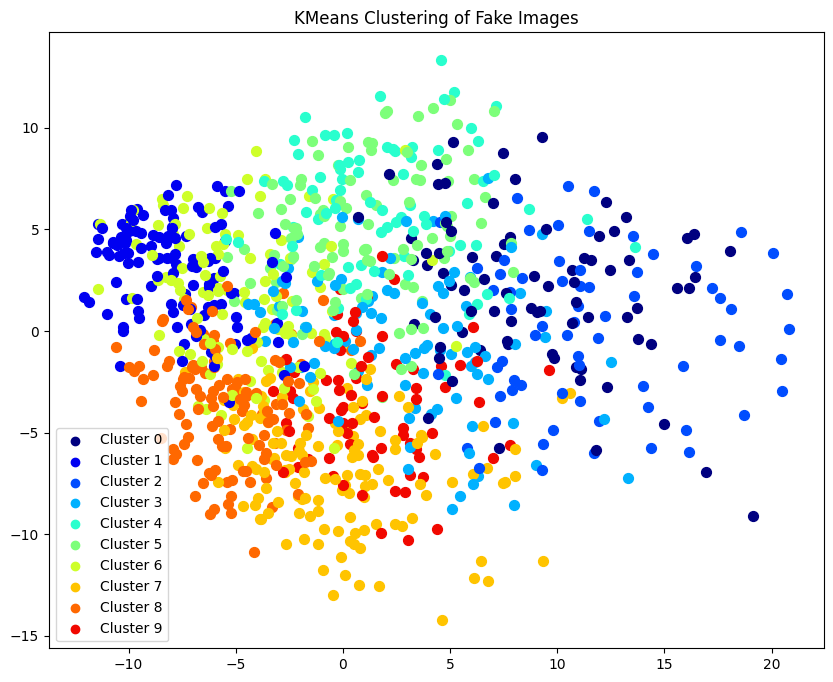

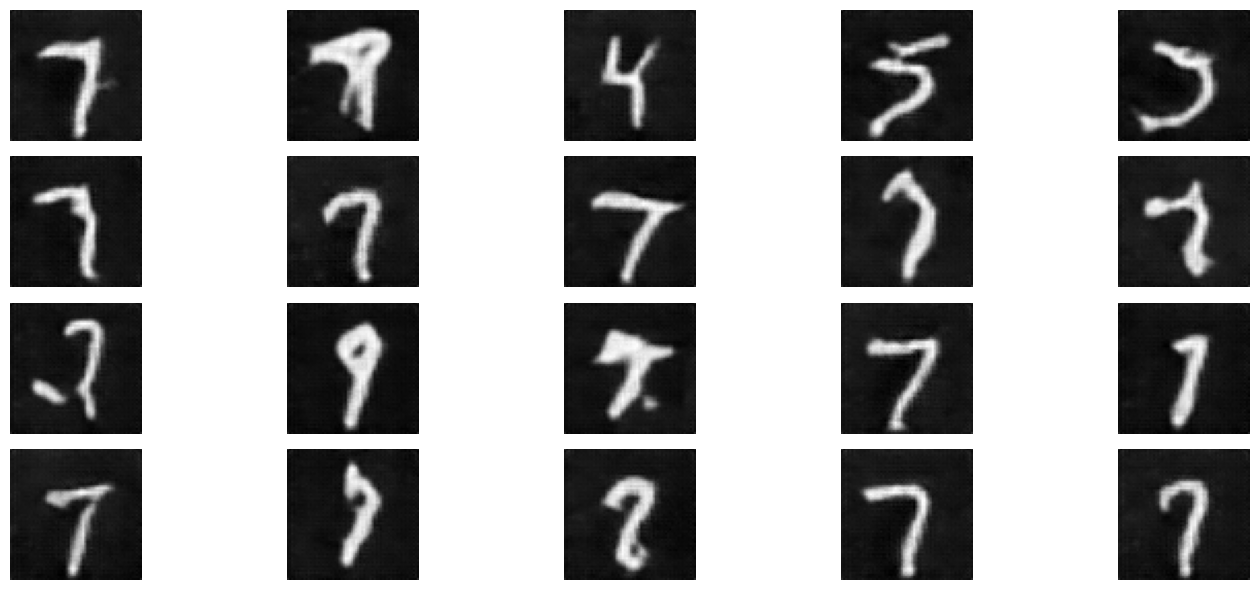

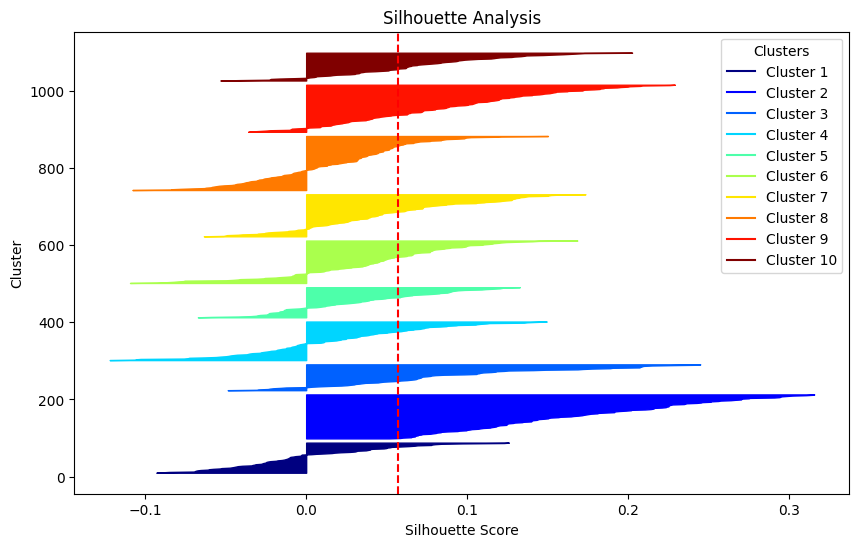

Average Silhouette Score: 0.0573
Average Intra-cluster Variance (Compactness): 0.1247


Results of: Origin model with beta=0.3


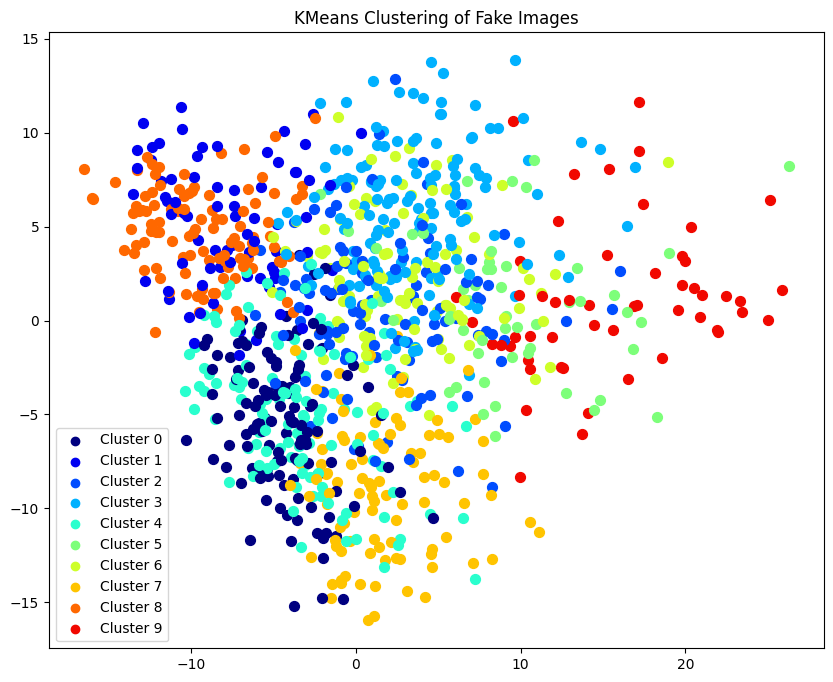

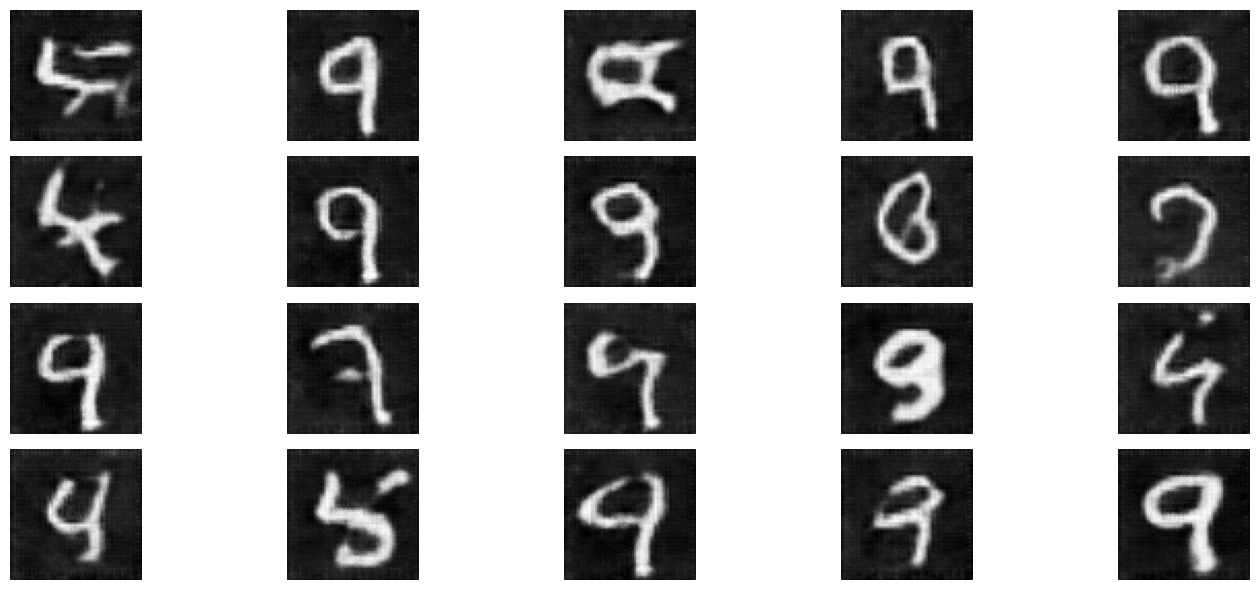

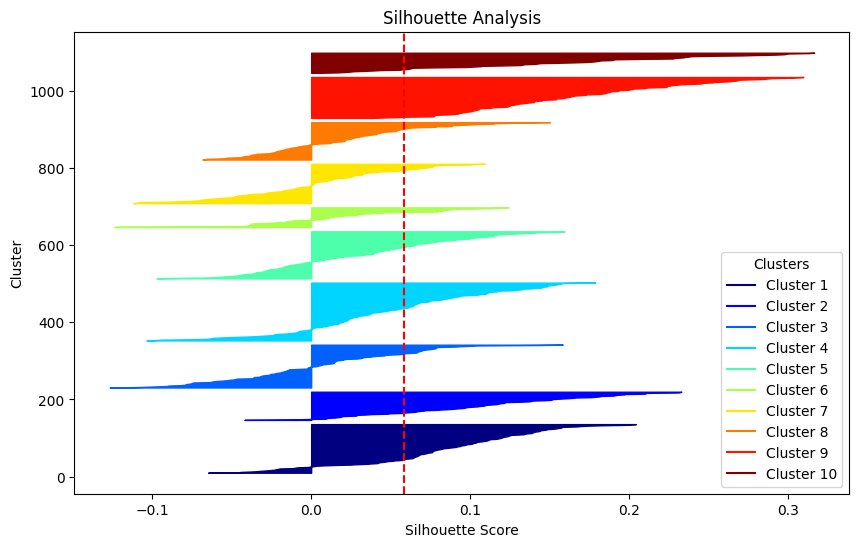

Average Silhouette Score: 0.0587
Average Intra-cluster Variance (Compactness): 0.1727


Results of: Origin model with learning rate=0.0001


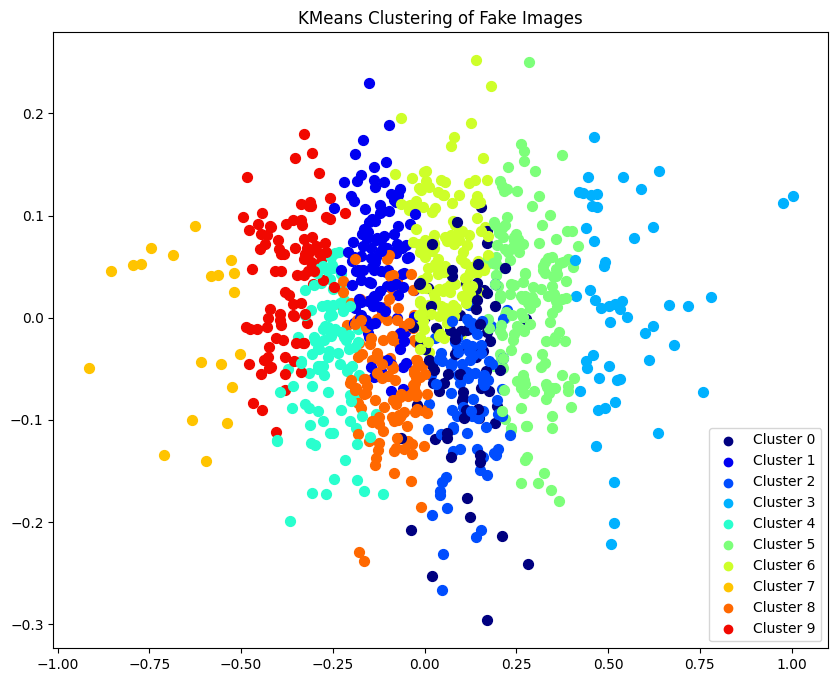

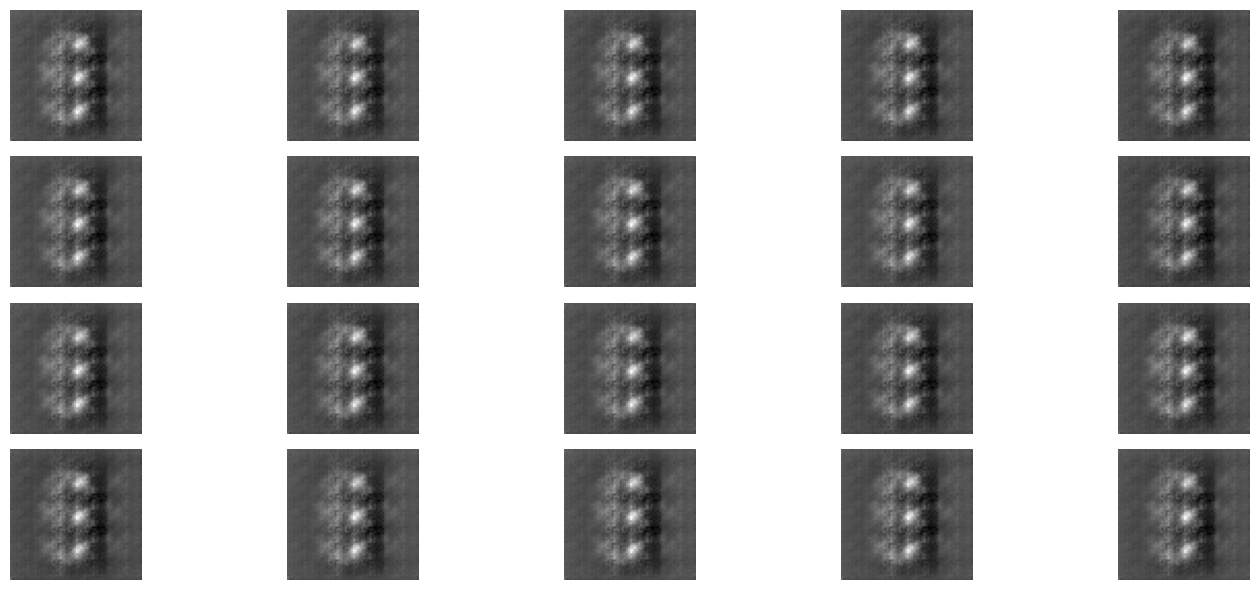

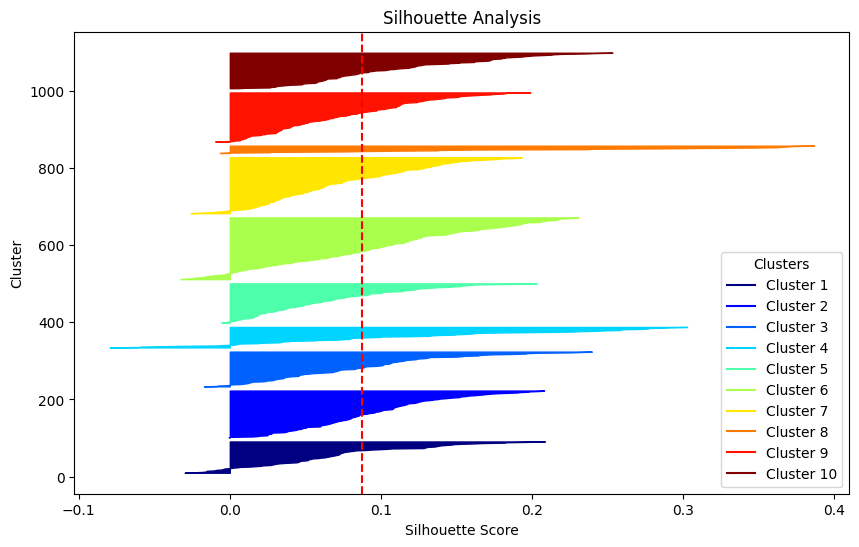

Average Silhouette Score: 0.0876
Average Intra-cluster Variance (Compactness): 0.0029


Results of: Origin model with hinge loss


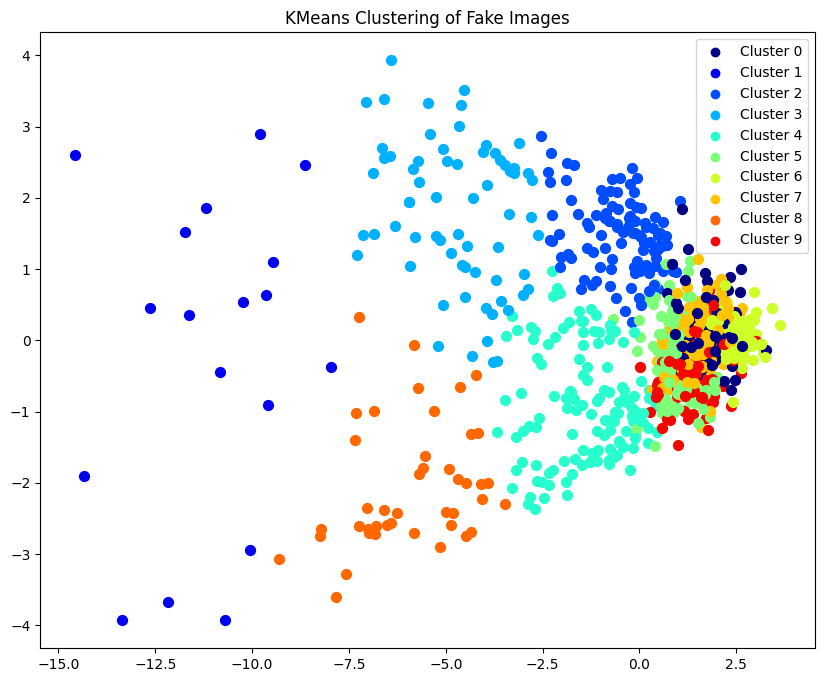

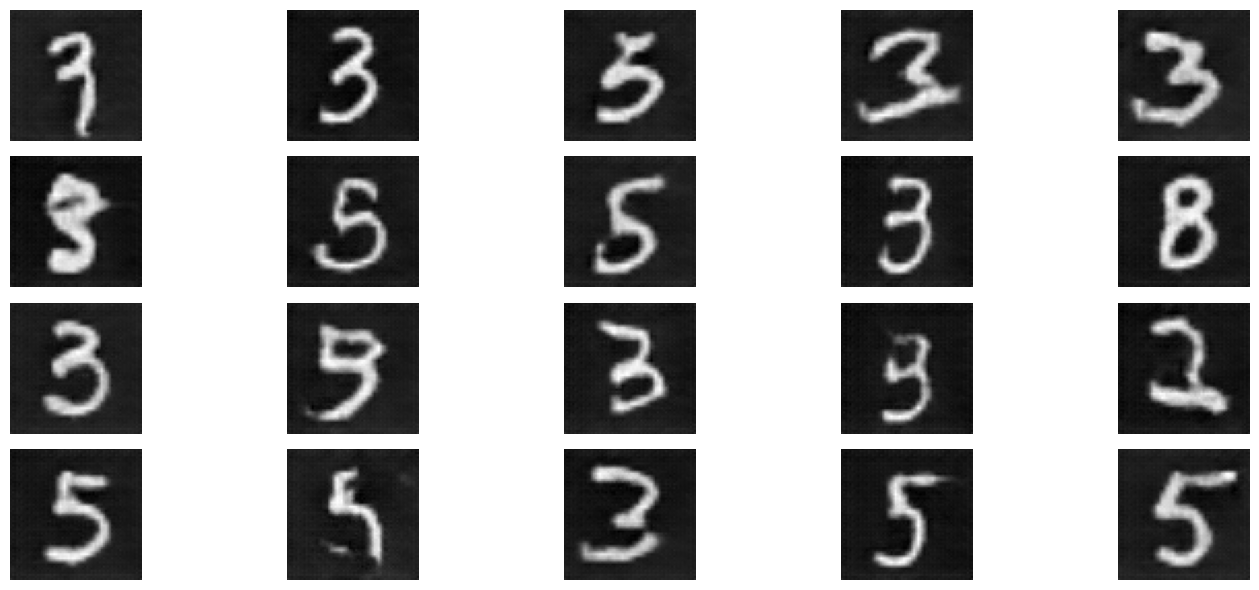

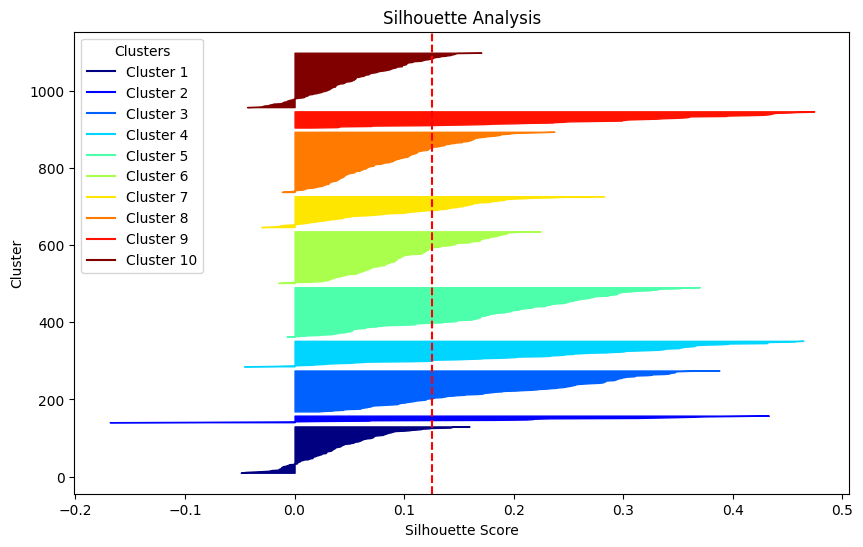

Average Silhouette Score: 0.1257
Average Intra-cluster Variance (Compactness): 0.0052


In [46]:
model_beta = '/content/mnist_model_beta0.3.pth'
model_lr = '/content/mnist_model_lr0.0001.pth'
model_origin = '/content/mnist_model_same_as_paper.pth'
hinge_loss = '/content/mnist_hinge_loss_30epochs.pth'

def test_reslts(model_path, class_index):
  chosen_model = load_model(model_path)
  images = generate_images(chosen_model, num_images=1000, nz=100, device='cpu')
  labels = kmeans_cluster_images(images, n_clusters=10)
  cluster_images(class_index, labels, images)
  evaluate_clustering(images, labels)

model_names = ['Origin model',
                'Origin model with beta=0.3',
               'Origin model with learning rate=0.0001',
               'Origin model with hinge loss']

class_of_nine = [8,7,7,7]
i=0
for model in [model_origin, model_beta, model_lr, hinge_loss]:
  print('')
  print('')
  print(f'Results of: {model_names[i]}')
  test_reslts(model, class_of_nine[i])
  i+=1

### CelebA images

Example of generated images using the generator with the self attention layer

In [10]:
ngpu=1
nz=100
ngf=64
nc=3
model_path = 'model_and_self_attention.pth'
# Create model instance
model = GeneratorSA(ngpu, nz, ngf, nc).to('cpu')
# Load the saved dictionary
checkpoint = torch.load(model_path, map_location='cpu')
# # Extract only the generator's weights
model.load_state_dict(checkpoint['generator_state_dict'], strict=False)
# # Set model to evaluation mode
model.eval()

# img = fake_images[i].squeeze().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
#     ig = (img - img.min()) / (img.max() - img.min())

GeneratorSA(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): SelfAttention(
      (query): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (7): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pad

In [11]:
from torchvision.utils import save_image
def generate_images(model, num_images, nz, device):
  os.makedirs('generated', exist_ok=True)
  nz = 100
  latent_vectors = torch.randn(num_images, nz, 1, 1)  # Shape: (8, 100, 1, 1)

  # Generate images
  with torch.no_grad():  # No need to track gradients
      fake_images = model(latent_vectors).cpu()

  # Convert to NumPy and plot
  # fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
  for i in range(num_images):
      img = fake_images[i].squeeze().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
      ig = (img - img.min()) / (img.max() - img.min())
      img_tensor = torch.tensor(img).permute(2, 0, 1)  # Convert back to (C, H, W)
      img_path = os.path.join('generated', f"generated_{i+1}.png")
      save_image(img_tensor, img_path, normalize=True)
  print(f"Saved {num_images} images to {'generated'}")

In [12]:
generate_images(model, 100, nz, 'cpu')

Saved 100 images to generated


To evaluate the quality of our generated images, we use the **Fréchet Inception Distance (FID)** — a widely accepted metric for comparing the similarity between two datasets of images. FID measures the distance between feature distributions of real and generated images, extracted using a pretrained **Inception v3** model. A lower FID indicates that the generated images are more similar to real ones in terms of visual fidelity and diversity.

We chose FID specifically because you recommended it in the course/project materials and beacuse it effectively captures both the **mean and covariance** of feature representations, providing a more reliable measure than simple pixel-wise distances.


In [20]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import scipy.linalg
from PIL import Image
from tqdm import tqdm
import os

# Load Inception v3 model
inception = models.inception_v3(pretrained=True, transform_input=False)
inception.fc = torch.nn.Identity()  # Remove final classification layer
inception.eval()

# Transformation function for input images
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def get_features(image_paths, model):
    """Extract features from a list of image paths using Inception v3"""
    features = []
    for img_path in tqdm(image_paths, desc="Extracting features"):
        img = Image.open(img_path).convert('RGB')
        img = transform(img).unsqueeze(0)
        with torch.no_grad():
            feat = model(img).cpu().numpy().flatten()
        features.append(feat)
    return np.array(features)

def calculate_fid(mu1, sigma1, mu2, sigma2):
    """Compute the FID score between two distributions"""
    diff = mu1 - mu2
    cov_mean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)

    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * cov_mean)
    return fid

# Paths to your images
generated_images_path = '/content/generated'
celeba_images_path = '/content/datasets/celeba/img_align_celeba'

# Load image file paths
gen_images = [os.path.join(generated_images_path, f) for f in os.listdir(generated_images_path) if f.endswith('.png')]
real_images = [os.path.join(celeba_images_path, f) for f in os.listdir(celeba_images_path) if f.endswith('.jpg')]
real_images = real_images[:100]

# Extract features
gen_features = get_features(gen_images, inception)
real_features = get_features(real_images, inception)

# Compute mean and covariance
mu_gen, sigma_gen = gen_features.mean(axis=0), np.cov(gen_features, rowvar=False)
mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)

# Compute FID score
fid_score = calculate_fid(mu_gen, sigma_gen, mu_real, sigma_real)
print(f"FID Score: {fid_score:.2f}")


Extracting features: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


FID Score: 141.26


### Human classifier, description below

🤖 Classifier-Based Evaluation of Generated Images

In addition to using FID, we experimented with evaluating the generated images using a **pretrained classifier** trained to distinguish between "person" and "not person." This provides an intuitive way to see how our generated samples align with the expected real-world category (in our case, faces from the CelebA dataset).

We generated 10 test images using our model and passed them through the classifier after applying appropriate preprocessing (resize, normalization, etc.).

**Observation**: The classifier predicted that **all images were "not person"**. This could be due to either:
- Insufficient quality or realism in the generated samples
- Classifier being overly strict or miscalibrated for these kinds of synthetic images.
- We think that the main reason is that it was trained on real people and not our generated ones, yet we do believe it is the right way to do it.

Despite the incorrect predictions, this step provides an additional perspective on the realism of our outputs. It complements FID by offering semantic-level insight into how a trained model perceives the images, and may help guide further improvements.


In [21]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class PascalVOCDataset(Dataset):
    def __init__(self, root, year="2012", image_set="train", transform=None):
        self.dataset = VOCDetection(root=root, year=year, image_set=image_set, download=True)
        self.transform = transform
        self.data = []

        for img, target in self.dataset:
            objects = target["annotation"]["object"]

            # Check if 'person' is in the objects
            is_person = any(obj["name"] == "person" for obj in objects)
            label = 1 if is_person else 0

            self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize images
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

# Load Train & Validation Sets
train_dataset = PascalVOCDataset(root="./data", image_set="train", transform=transform)
val_dataset = PascalVOCDataset(root="./data", image_set="val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#Load Pretrained ResNet and Modify for Binary Classification
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Output 2 classes: Person (1) or Not (0)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


100%|██████████| 2.00G/2.00G [01:49<00:00, 18.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


Epoch [1/5], Loss: 0.3165
Epoch [2/5], Loss: 0.1331
Epoch [3/5], Loss: 0.0497
Epoch [4/5], Loss: 0.0217
Epoch [5/5], Loss: 0.0294
Validation Accuracy: 88.80%


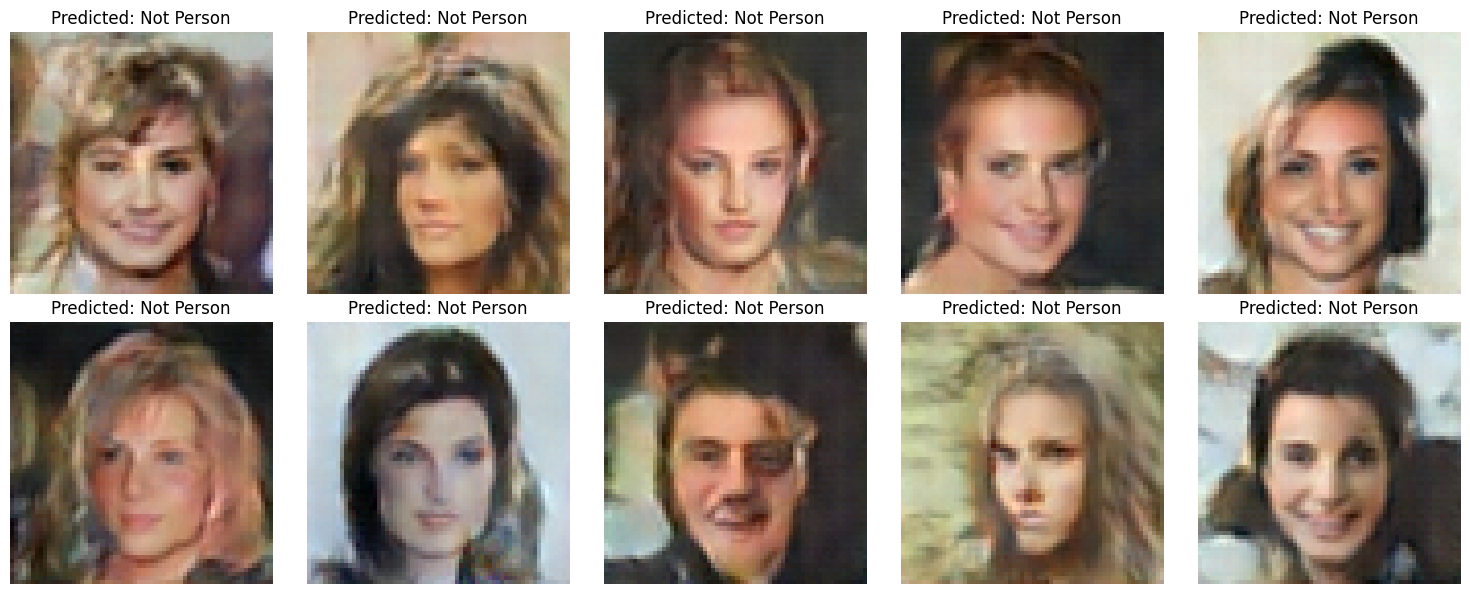

In [26]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

ngpu=1
nz=100
ngf=64
nc=3
model_path = 'model_and_self_attention.pth'
generator = GeneratorSA(ngpu, nz, ngf, nc).to('cpu')
# Load the saved dictionary
checkpoint = torch.load(model_path, map_location='cpu')
# # Extract only the generator's weights
generator.load_state_dict(checkpoint['generator_state_dict'], strict=False)
# # Set model to evaluation mode
generator.eval()

# Function to preprocess the images for the classifier
def preprocess_for_classifier(image_tensor):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize to match classifier input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize like ImageNet
    ])
    return transform(image_tensor)

# Generate 10 test images
nz = 100  # Latent vector size
batch_size = 10
z = torch.randn(batch_size, nz, 1, 1)  # Generate random noise

with torch.no_grad():  # No need to track gradients
    fake_images = generator(z).cpu() # Generate images and move them to CPU

# Preprocess the images for the classifier
test_images = [preprocess_for_classifier(fake_images[i]) for i in range(batch_size)]
test_images_tensor = torch.stack(test_images)  # Stack the images into a batch

# Run the classifier on the generated test images
model.eval()
with torch.no_grad():
    outputs = model(test_images_tensor.to(device))
    _, predicted = torch.max(outputs, 1)  # Get the predicted class (0 or 1)

# Display the images with their predicted labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns
for i, ax in enumerate(axes.flatten()):
    img = fake_images[i].squeeze().permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
    ig = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    ax.imshow(ig)
    ax.axis("off")
    ax.set_title(f"Predicted: {'Person' if predicted[i] == 1 else 'Not Person'}")

plt.tight_layout()
plt.show()
